In [4]:
import sys

sys.executable

'/Users/riddhimanadib/.virtualenvs/dataanalysis/bin/python3'

# Assumption

Let us assume a known Causal DAG with 3 variables.

1. treatment - drug - marked by X 
2. outcome - survival time - marked by Y 
3. confounding - sex - marked by Z 

In [1]:
# import pydot

# graph = pydot.Dot(graph_type='digraph') # digraph means directed graph

# # creating nodes is as simple as creating edges!
# # node_a = pydot.Node("Node A", style="filled", fillcolor="red")
# node_a = pydot.Node("Z (sex)")
# node_b = pydot.Node("X (drug)")
# node_c = pydot.Node("Y (survival)")

# graph.add_node(node_a)
# graph.add_node(node_b)
# graph.add_node(node_c)

# # graph.add_edge(pydot.Edge(node_d, node_a, label="and back we go again", labelfontcolor="#009933", fontsize="10.0", color="blue"))
# graph.add_edge(pydot.Edge(node_a, node_b))
# graph.add_edge(pydot.Edge(node_a, node_c))
# graph.add_edge(pydot.Edge(node_b, node_c))

# # and we are done
# # graph.write_png('example2_graph.png')

# from IPython.display import Image, display

# graph_plot = Image(graph.create_png())
# display(graph_plot)

--- 

# Experimentation

Now we assume we know the causal DAG and we simulate dataset based on our assumed causal DAG.

In [2]:
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import norm
import pandas as pd
import numpy as np
import random

### Parameters of simulations

We assume the <b>trial length</b> to be <b>50</b> and <b>number of test population</b> to be <b>20</b>. Our variables X and Z are <b>categorical variables</b> with values 0 or 1. 


For simplicity, we can assume X=0 means male, X=1 means female, and Z=0 means no drug presceibed, X=1 means drug prescribed.

In [3]:
trial_length = 50
population = 200

In [4]:
X = [0, 1]
Z = [0, 1]

In [5]:
# #     if sex == 0 and drug == 0:
# #         a = 0.025
# #     elif sex == 1 and drug == 0:
# #         a = 0.030
# #     elif sex == 0 and drug == 1:
# #         a = 0.010
# #     elif sex == 1 and drug == 1::
# #         a = 0.090

def get_survival_from_drug_sex(sex, drug, n):
    ''' 
    Survival time is calculated from sex and drug, using a exponential baseline hazard
    This shows survival time (Y) is being controlled by both sex (Z) and drug (X)
    '''
    a = 0.025 + 0.005 * sex - 0.015 * drug + 0.075 * sex * drug
    noise = np.random.uniform()
    return 5*exp(a*n) + noise

### General graph showing survival times for individuals

<img src="desmos.png" alt="General graph showing survival times for individuals" width="800"/>

In [6]:
def get_drug_from_sex(sex, population):
    # draw a uniform random number between 0 to 1, male > 0.75, female > 0.25
    subgroup_drug_sex = []
    bias = 0.25
    loop_length = 1000
    
    count = 0
    for i in range(loop_length):
        rand = np.random.uniform()
        if rand <= bias:
            count += 1
    percentage = (count / loop_length)
    subgroup_drug_sex.append(int(population/2 * percentage))
    subgroup_drug_sex.append(int(population/2 * (1-percentage)))
    
    count = 0
    for i in range(loop_length):
        rand = np.random.uniform()
        if rand <= bias:
            count += 1
    percentage = (count / loop_length)
    subgroup_drug_sex.append(int(population/2 * (1-percentage)))
    subgroup_drug_sex.append(int(population/2 * percentage))
            
    
    return subgroup_drug_sex

In [7]:
subgroup = get_drug_from_sex(Z, population)
subgroup

[25, 74, 73, 26]

In [8]:
data = pd.DataFrame(columns=['sex', 'drug', 'time', 'status'])

cumulative = 0
for k in range(len(subgroup)):
    for i in range(subgroup[k]):
        survival_time = get_survival_from_drug_sex(Z[k%2], X[k//2], i)
        if survival_time <= trial_length:
            status = 1
        else:
            survival_time = trial_length
            status = 0
        data.loc[cumulative+i] = [Z[k%2], X[k//2], survival_time, status]
    cumulative += subgroup[k]
    
data = data.reindex(np.random.permutation(data.index))
data = data.reset_index(drop=True)

In [9]:
data.sample(10)

,sex,drug,time,status
54,1.0,0.0,37.341340,1.0
151,1.0,1.0,39.628646,1.0
153,1.0,0.0,32.814338,1.0
166,1.0,0.0,17.593069,1.0
173,0.0,1.0,6.090205,1.0
30,1.0,1.0,19.829224,1.0
122,0.0,1.0,7.844070,1.0
50,1.0,1.0,8.745777,1.0
97,0.0,1.0,8.848738,1.0
140,0.0,1.0,8.319200,1.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
sex       198 non-null float64
drug      198 non-null float64
time      198 non-null float64
status    198 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [11]:
data.describe()

,sex,drug,time,status
count,198.000000,198.000000,198.000000,198.0
mean,0.505051,0.500000,13.378716,1.0
std,0.501242,0.501267,10.058502,0.0
min,0.000000,0.000000,5.267881,1.0
25%,0.000000,0.000000,6.910774,1.0
50%,1.000000,0.500000,8.940632,1.0
75%,1.000000,1.000000,15.415992,1.0
max,1.000000,1.000000,47.575645,1.0


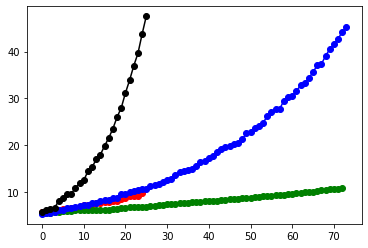

In [12]:
time00 = data[(data['sex'] == 0) & (data['drug'] == 0)].sort_values(by='time', ascending=True)['time']
time01 = data[(data['sex'] == 0) & (data['drug'] == 1)].sort_values(by='time', ascending=True)['time']
time10 = data[(data['sex'] == 1) & (data['drug'] == 0)].sort_values(by='time', ascending=True)['time']
time11 = data[(data['sex'] == 1) & (data['drug'] == 1)].sort_values(by='time', ascending=True)['time']

plt.plot(range(len(time00)), time00, 'r-o')
plt.plot(range(len(time01)), time01, 'g-o')
plt.plot(range(len(time10)), time10, 'b-o')
plt.plot(range(len(time11)), time11, 'k-o')

---

# Survival Analysis thorugh Kaplan Meier Fitter

In [13]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

ModuleNotFoundError: No module named 'lifelines'

### Survival time plotting of drug vs no drug group

In [ ]:
ix = (data['drug'] == 1)

kmf = KaplanMeierFitter()
kmf.fit(data['time'][~ix], data['status'][~ix], label='drug = 0')
ax = kmf.plot_survival_function()

kmf = KaplanMeierFitter()
kmf.fit(data['time'][ix], data['status'][ix], label='drug = 1')
ax = kmf.plot_survival_function(ax=ax)

### Survival time plotting of female vs male group

In [ ]:
ix = (data['sex'] == 1)

kmf = KaplanMeierFitter()
kmf.fit(data['time'][~ix], data['status'][~ix], label='sex = 0 (male)')
ax = kmf.plot_survival_function()

kmf = KaplanMeierFitter()
kmf.fit(data['time'][ix], data['status'][ix], label='sex = 1 (female)')
ax = kmf.plot_survival_function(ax=ax)

### Survival time plotting of female vs male group, with drug vs no drug

In [ ]:
i1 = (data['drug'] == 0) & (data['sex'] == 0)
i2 = (data['drug'] == 0) & (data['sex'] == 1)
i3 = (data['drug'] == 1) & (data['sex'] == 0)
i4 = (data['drug'] == 1) & (data['sex'] == 1)

kmf = KaplanMeierFitter()
kmf.fit(data['time'][i1], data['status'][i1], label='drug = 0, sex = 0')
ax = kmf.plot_survival_function()

kmf = KaplanMeierFitter()
kmf.fit(data['time'][i2], data['status'][i2], label='drug = 0, sex = 1')
ax = kmf.plot_survival_function(ax=ax)

kmf = KaplanMeierFitter()
kmf.fit(data['time'][i3], data['status'][i3], label='drug = 1, sex = 0')
ax = kmf.plot_survival_function(ax=ax)

kmf = KaplanMeierFitter()
kmf.fit(data['time'][i4], data['status'][i4], label='drug = 1, sex = 1')
ax = kmf.plot_survival_function(ax=ax)

---

# Survival Analysis thorugh Cox PH Model


### When we dont have data on confounding variable (here, Z {sex} )

In [ ]:
data_without_sex = data[['drug', 'time', 'status']].copy()
cph_Z_missing = CoxPHFitter()
cph_Z_missing.fit(data_without_sex, 'time', 'status')
cph_Z_missing.print_summary()

In [ ]:
cph_Z_missing.check_assumptions(data_without_sex)

---

### When we DO have data on confounding variable (here, Z {sex} )

In [ ]:
cph = CoxPHFitter()
cph.fit(data, 'time', 'status')
cph.print_summary()

In [ ]:
cph.check_assumptions(data)

---

In [ ]:
cph_Z_missing.hazard_ratios_['drug']

In [ ]:
cph.hazard_ratios_['drug']

### We see that, without data on confounding, drug has a HR of 1.81, which means the drug is hazardous at any instant of the trial and increases risk of hazard (death) by 80%. 


### However it is 0.87 with data on confounding, meaning the drug is NOT hazradous and reduces chance of hazard by 13%.

---

# Limitations

1. Assumed exponential baseline hazard: we should look into linear distribution, or in general, Weibull distribution.
2. Assumed single confounding: explore with multiple backdoor open.
3. Assumed confounding as categorical variable: explore continuous-value confouding.
4. Assumed bias and effect of sex on drug and outcome: We can iterate over varying values of bias and effects of one variable over another.

In [ ]:
data.to_csv(r'strong_bias_data_1.csv', index = None, header=True)